# Filtering and Resampling

Filtering seismic data alows us to increase the signal-to-noise ratio of specific frequency ranges that we are interested in.  
Remember that (from Stein and Wysession Figure 2.4-7) the range of frequencies for different types of seismic waves cover a wide
spectrum, with:
- reflection seismology often interested in signals in the 10Hz-1kHz range,
- earthquake seismology usually concerned with data in the 0.01-50Hz range and
- studies of normal modes thinking about frequencies in the 0.00001-0.01Hz range.
Surface waves also have different frequency content to body waves.  Because of this, we can filter the same data in different
*pass-bands* to look at different features of the seismogram. A nice example of this is the seismogram of the Kaikoura 2016
M7.8 earthquake, recording on White Island. While the Kaikoura earthquake was happening, the aftershock sequence of the Te
Araroa M7.2 earthquake was going on (see Warren-Smith et al., 2018 for more details). By filtering in different passbands we
can see the surface waves from Kaikoura as well as the more local seismicity, which has a higher frequency content.

To include:
- [x] Different filter types
- [ ] Filter slope and aliasing
- [ ] Causal and acausal
- [ ] How filters are represented (poles and zeros)
- [x] Plotting various filter windows and their effect on data (both time and freq domain)
- [ ] Resampling - sinc as well as fourier - need to prefilter

In [1]:
# Set up notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from obspy import read, UTCDateTime
from obspy.clients.fdsn import Client
from scipy import signal, fftpack
plt.style.use('ggplot') # Makes plots work well with dark theme

Lets download some data from GeoNet for the [WIZ station](https://www.geonet.org.nz/data/network/sensor/WIZ), which is a 
broadband sensor on the White Island volcano.
We will get data from the Kaikoura origin-time to quarter of an hour later.

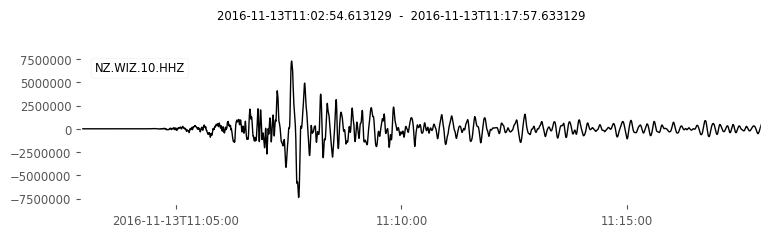

In [2]:
client = Client("GEONET")
kaikoura_origin_time = UTCDateTime(2016, 11, 13, 11, 2, 56)
st = client.get_waveforms(
    network="NZ", station="WIZ", channel="HHZ", location="10", 
    starttime=kaikoura_origin_time, endtime=kaikoura_origin_time + (15 * 60))
fig = st.plot()

We can see the initial high-frequency body waves followed by strong low-frequency energy of the surface waves. 
You will also note that it takes a reasonable time for the first arriving seismic energy to reach this far from the earthquake.

We can visualise the frequencies nicely by looking at a spectrogram.  The spectrogram computes the frequency content
in moving windows along the trace and plots the normalised power of those frequencies as different colours. In the spectrogram
below you can clearly see the dominant low-frequency energy.

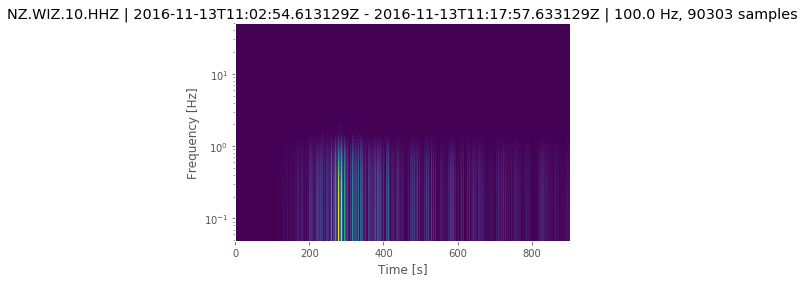

In [3]:
fig = st[0].spectrogram(log=True)

Lets try and looks at just the high-frequencies.  Obspy has a convenient *filter* method on Stream and Trace objects.  We will use that before digging in to how
filtering works.

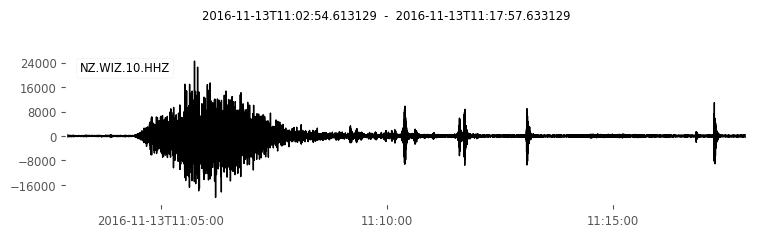

In [4]:
st_highpass = st.copy().filter("highpass", freq=2.)
fig = st_highpass.plot()

We can see a lot of emmergent high-frequency energy associated with body waves from the Kaikoura earthquake itself in the 
beginning of this wave-train. However, the later bursts of energy are likely a more local source. We couldn't see those in
the original, broadband waveform. Lets have a look at one of those more local events.

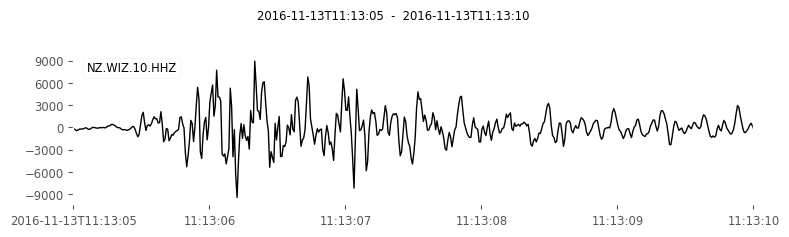

In [5]:
fig = st_highpass.plot(
    starttime=UTCDateTime(2016, 11, 13, 11, 13, 5),
    endtime=UTCDateTime(2016, 11, 13, 11, 13, 10))

This is likely to be an aftershock of the Te Araroa sequence - there is dominant high-frequency energy. 
Unfortunately, stations closer to the Te Araroa epicenter have clipped waveforms - the signal from Kaikoura
exceeded the dynamic range of the sensor, which makes filter operations unstable.

Now lets try and just look at the low-frequency energy.

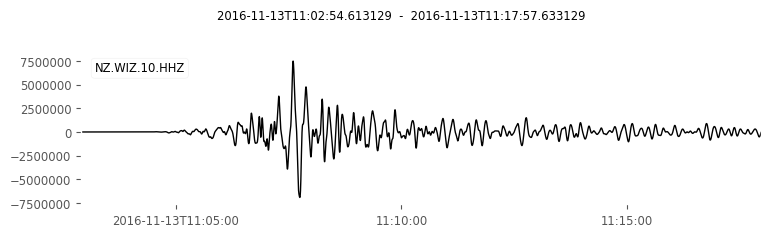

In [6]:
st_lowpass = st.copy().filter("lowpass", freq=.25)
fig = st_lowpass.plot()

Now that we know that filters can be useful for various things, including separating energy from different sources, lets think about how filters work.

## How filters work

Filters work to remove energy at certain frequencies. This involves convolving some filter series with your data. In the time domain, convolution can be
a slow process, however, in the frequency domain, convolutions are simple multiplications. Because multiplication is a less computationally
expensive operation than convolution, filtering is often undertaken in the frequency domain.

In the next section we will think about some basic linear filters and look at different bandpass types, different filter window types, and
play with the order of the filters and the frequency ranges used.

First we will set up a few functions that:
1. Design a filter in the frequency domain using scipy's 
   [iirfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html#scipy.signal.iirfilter) function.
2. Apply the filter and plot the results in the time and frequency domains.

It is worth noting that these filters only work for fairly simple filters, and in more general cases the use of
[second-order sections](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfilt.html#scipy.signal.sosfilt)
is recommended.  Obspy uses this internally when you use the *filter* method.

In [7]:
def design_filter(sample_rate, data_length, corners, order=4, window_type='butter',
                  filter_type='bandpass'):
    """
    Design a frequency-domain filter.
    
    :type sample_rate: float
    :param sample_rate: Sampling-rate in Hz
    :type data_length: int
    :param data_length: 
        Length of data to apply to - will use the next-fast fft length from this.
    :type corners: array-like
    :param corners: list of corners for filter in order, in Hz
    :type order: int
    :param order: Filter order
    :type window_type: str
    :param window_type: 
        Type of window to use, must be one of:
        'butter' : Butterworth
        'cheby1': Chebyshev I
        'cheby2': Chenyshev II
        'ellip': Cauer/elliptic
        'bessel': Bessel/Thomson
    :type filter_type: str
    :param filter_type: 
        Type of band to use, must be one of: 
        'bandpass', 'lowpass', 'highpass', 'bandstop'
    """
    nyquist = .5 * sample_rate
    # Check that highpass is usefully less than the nyquist
    if max(corners) > (nyquist * .98):
        raise NotImplementedError(
        "Highcut {0} is higher than Nyquist {1}.".format(
            max(corners), nyquist))
    fft_len = fftpack.next_fast_len(data_length)
    # N is the "order" of the filter, Wn is the filter window.
    b, a = signal.iirfilter(
        N=order, Wn=corners, btype=filter_type, analog=False, ftype=window_type,
        output='ba', fs=sample_rate)
    _, filt = signal.freqz(b, a, worN=fft_len, fs=sample_rate)
    return filt


def filter_and_plot(data, dt, filt):
    """
    Filter data using a simple filter and plot the data, the transfer 
    function and the filtered data. Plots will be in both time and
    frequency domain.
    
    Note: Filter is maximum-phase
    
    :type data: `numpy.ndarray`
    :param data: Data to be filtered
    :type dt: float
    :param dt: Sample-interval (assumed to be in seconds).
    :type filt: `numpy.ndarray`
    :param filt: Frequency-domain representation of filter.
    """  
    N = len(data)
    filt_time = fftpack.ifft(filt)  # Generate a time-domain representation of the filter
    x_time = np.arange(0, N * dt, dt)
    
    fft_len = fftpack.next_fast_len(N)  # Find the next fast length for the FFT
    data_freq = fftpack.fft(data, n=fft_len)
    filtered_freq = data_freq * filt  # Filtering is multiplication in frequency domain
    filtered = fftpack.ifft(filtered_freq)
   
    x_freq = np.linspace(0.0, 1.0 / (2. * dt), int(N / 2))
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    
    axes[0][0].plot(x_time, data)
    axes[0][0].set_title("Input data")
    axes[0][1].plot(np.arange(0, len(filt_time) * dt, dt), np.real(filt_time))
    axes[0][1].set_title("Filter")
    axes[0][2].plot(x_time, np.real(filtered))
    axes[0][2].set_title("Filtered")
    
    axes[1][0].semilogx(x_freq, 2./N * np.abs(data_freq[:N//2]))    
    axes[1][1].semilogx(x_freq, 2./N * np.abs(filt[:N//2]))
    axes[1][2].semilogx(x_freq, 2./N * np.abs(filtered_freq[:N//2]))
    
    for ax in axes[0]:
        ax.set_xlabel("Time (s)")
        ax.autoscale(enable=True, axis='both', tight=True)
    for ax in axes[1]:
        ax.set_xlabel("Frequency (Hz)")
        ax.autoscale(enable=True, axis='both', tight=True)
    return fig

### Lowpass filtering

We will first set up a simple low-pass filter.  Low-pass filters **remove** high frequencies, and allow low frequencies
to *pass-through*.

**Exercise:** Play with different window types, low passes and filter orders.

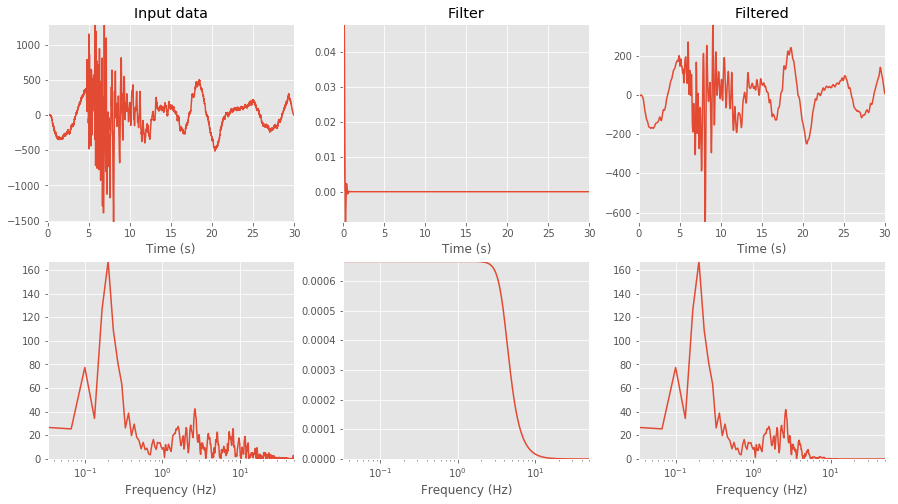

In [8]:
tr = read()[0]
tr = tr.detrend()  # Data must be de-trended before filtering

filt = design_filter(
    sample_rate=tr.stats.sampling_rate, data_length=tr.stats.npts,
    corners=[2.], order=4, window_type="butter",
    filter_type="lowpass")
fig = filter_and_plot(tr.data, tr.stats.delta, filt=filt)

### Highpass filtering

High-pass filters **remove** low frequencies, and allow high frequencies to *pass-through*.

**Exercise:** Play with different window types, high passes and filter orders.

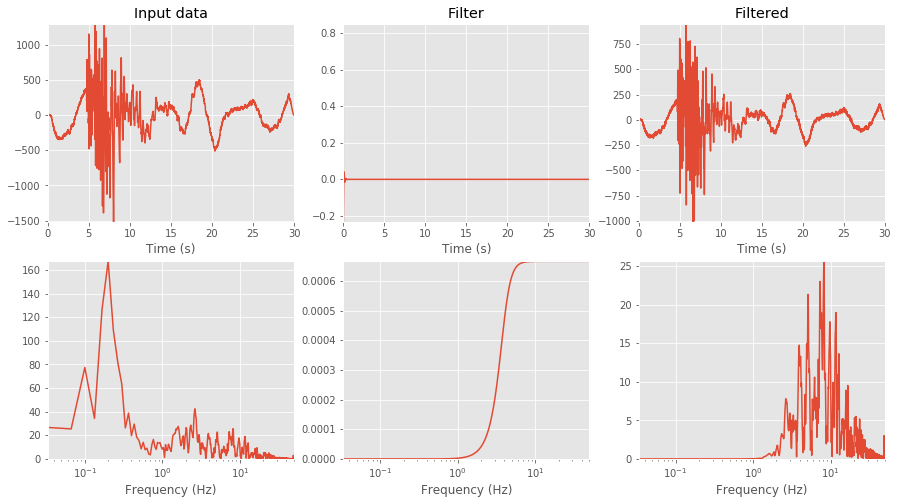

In [10]:
tr = read()[0]
tr = tr.detrend()  # Data must be de-trended before filtering

filt = design_filter(
    sample_rate=tr.stats.sampling_rate, data_length=tr.stats.npts,
    corners=[2.], order=4, window_type="butter",
    filter_type="highpass")
fig = filter_and_plot(tr.data, tr.stats.delta, filt=filt)

### Bandpass filtering

Bandpass filters allow a range of frequencies to pass through.  We commonly refer to the frequencies that are retained as
the *pass-band*.

**Exercise:** Play with different window types and low and high cuts. You can add more than two corners to make a more complex filter.

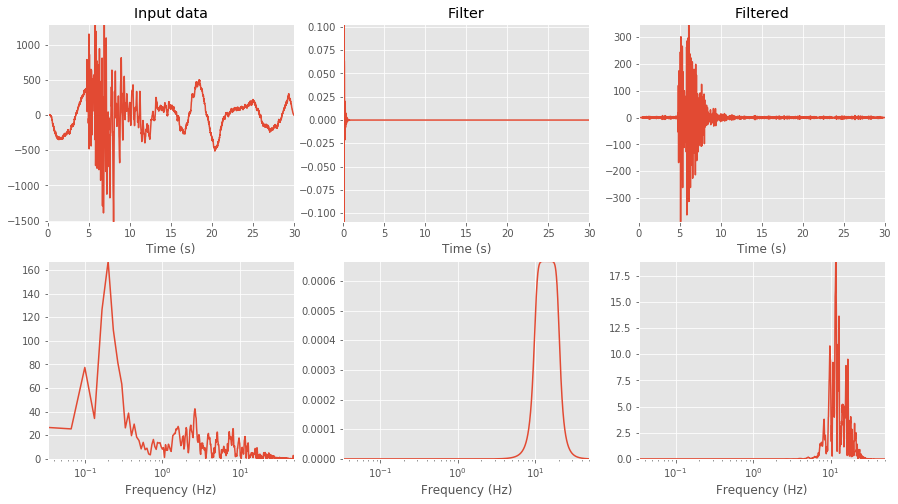

In [11]:
tr = read()[0]
tr = tr.detrend()  # Data must be de-trended before filtering

filt = design_filter(
    sample_rate=tr.stats.sampling_rate, data_length=tr.stats.npts,
    corners=[5., 10.], order=4, window_type="butter",
    filter_type="bandpass")
fig = filter_and_plot(tr.data, tr.stats.delta, filt=filt)